<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/image_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import os
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'

image_files = os.listdir(image_dir)
print(len(image_files))

# get the path of image in the list
image_path = os.path.join(image_dir, image_files[0])

579


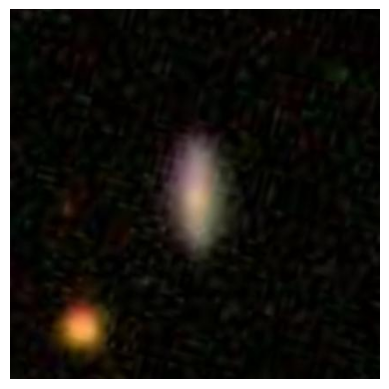

In [77]:
# print out the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [78]:
import pandas as pd

csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_label.csv'
column_names = ['index', 'class']

df = pd.read_csv(csv_file_path, names=column_names)
# create a dictionary for index and class
index_to_class = dict(zip(df['index'], df['class']))

Index: 115384
Class0


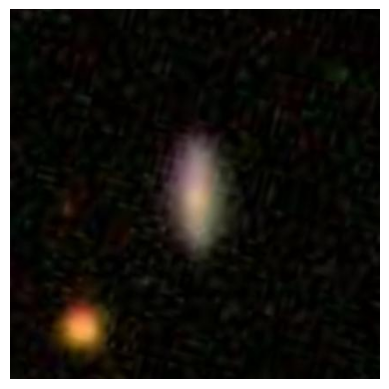

In [79]:
image_path = os.path.join(image_dir, image_files[0])
filename = os.path.basename(image_path)
index = filename.split('.')[0]
index = int(index)

# Print the index
print("Index:", index)
print(index_to_class[index])

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

Refer to the filters used in exercise 7

In [80]:
# copy the filters from ex7
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib

(424, 424, 3)


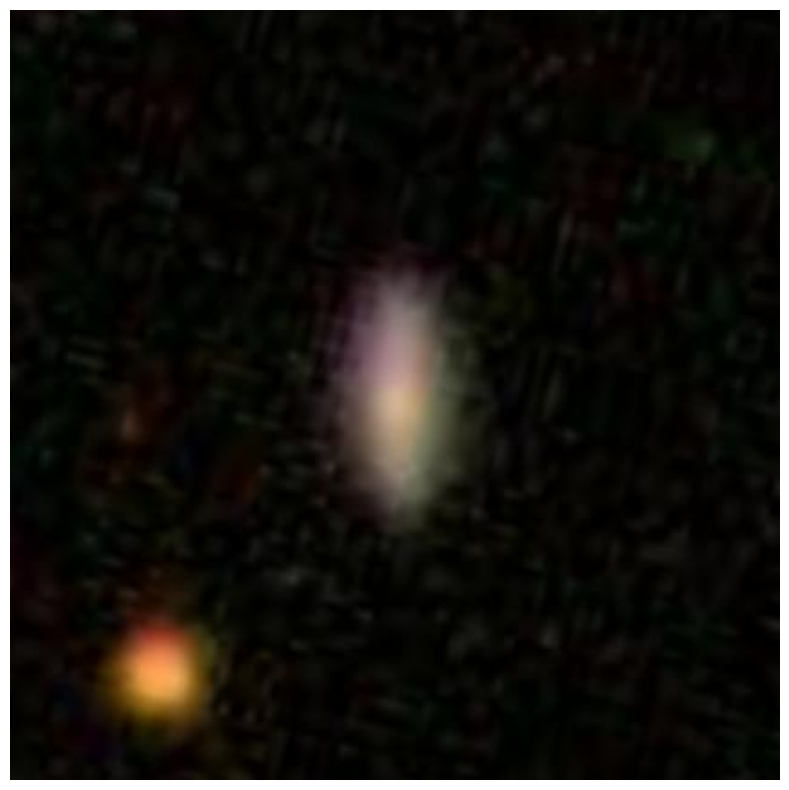

In [81]:
image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
print(im.shape)

# display the image
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(im)
plt.show()

In [82]:
def display_img_colorbar(img):
  # display the points
  fig, ax = plt.subplots(figsize=(15, 10))
  im_ax = plt.imshow(img, cmap='gray')
  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im_ax, cax=cax)
  plt.show()

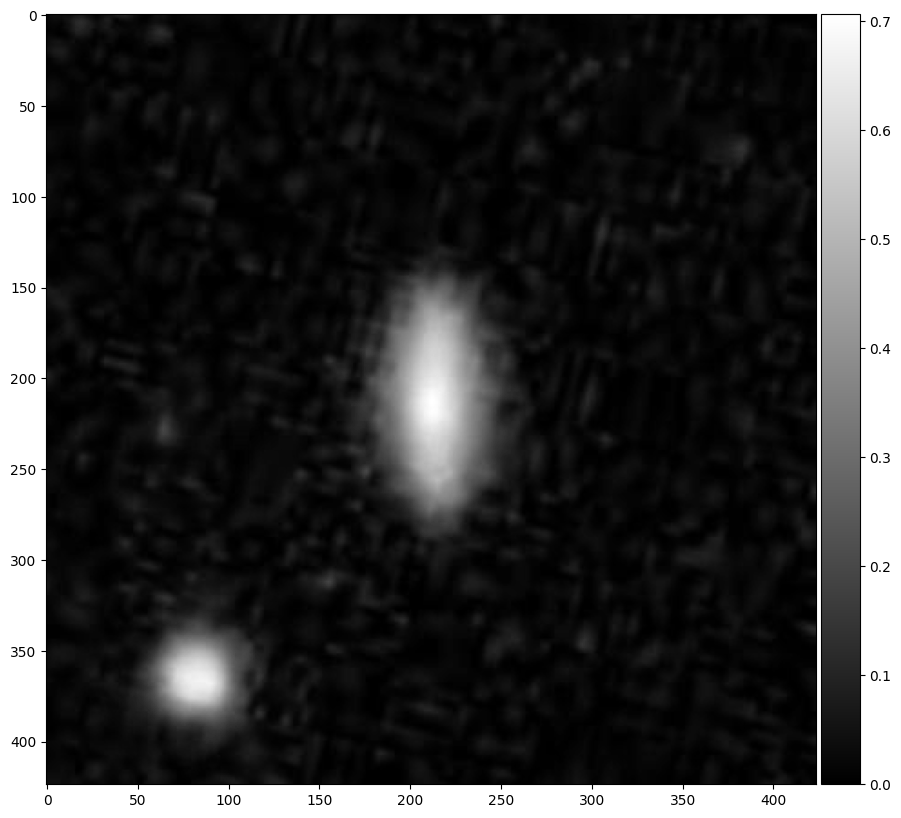

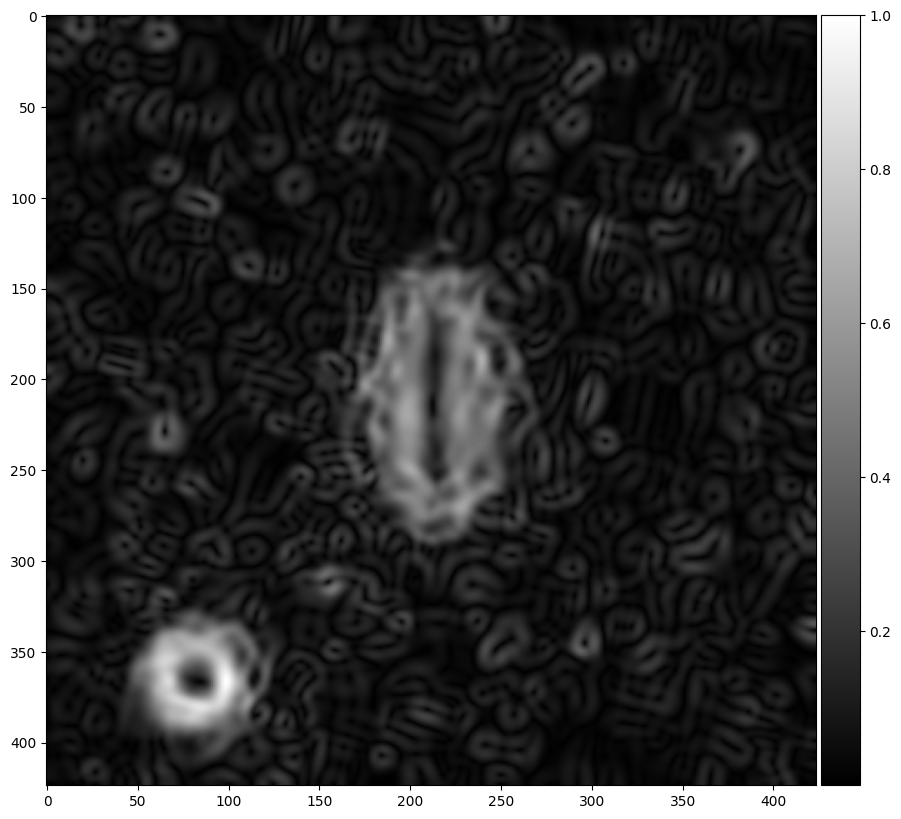

In [83]:
# convert to grayscale
if np.max(im)>1:
  im = im.astype(np.float32)/255.0
im_gray = np.mean(im, axis=2)

# compute edges of the image
# the larger kernel size is, the clearer the image we have. Small kernal would make the image fuzzy and full of noises.
sobelx = cv2.Sobel(im_gray, cv2.CV_32F, 1, 0, ksize=31) # Find x and y gradients
sobely = cv2.Sobel(im_gray, cv2.CV_32F, 0, 1, ksize=31)
magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
magnitude = magnitude / np.max(magnitude) # normalize

display_img_colorbar(im_gray)
display_img_colorbar(magnitude)

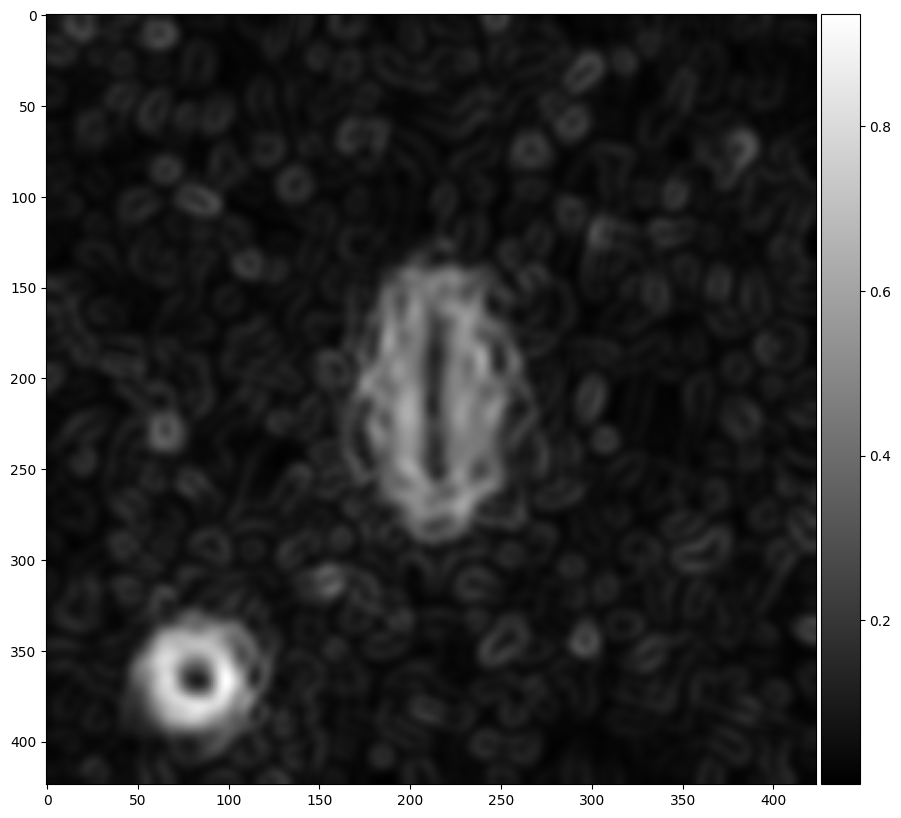

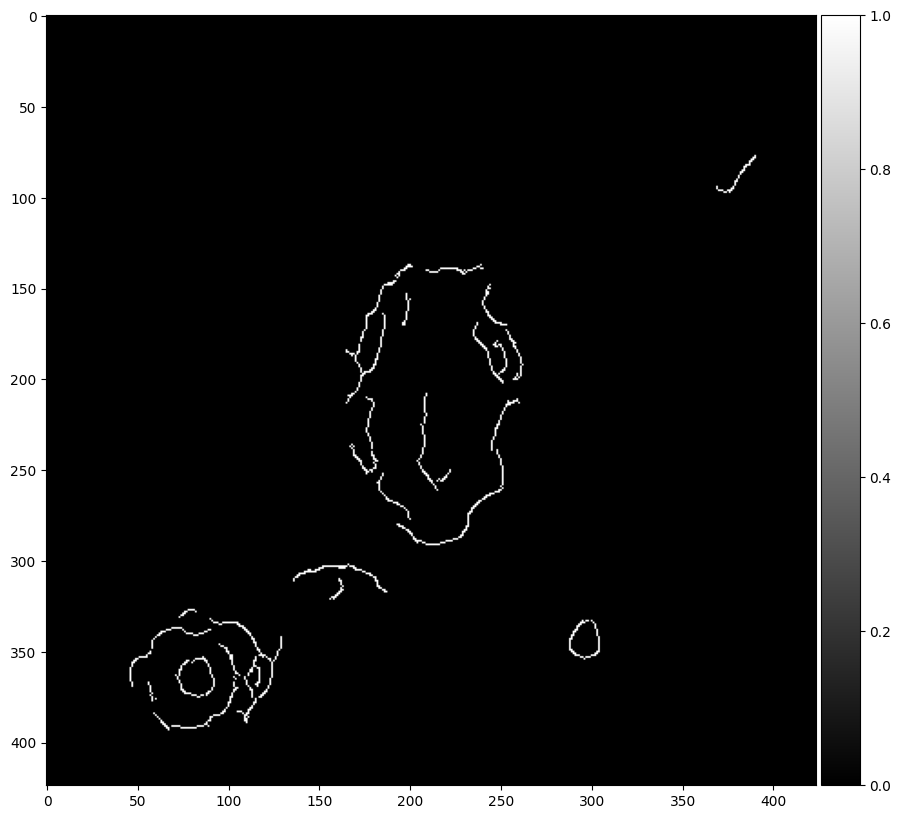

In [84]:
# GaussianBlur before canny to reduce the noise
# Arguments: kernel size (width, height), sigmaX and sigmaY
# Default setting sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
# if the kernel has wider tails, the image will be more blurred or higher sigma
blurred_im = cv2.GaussianBlur(magnitude, (7, 7), sigmaX=16, sigmaY=10)
display_img_colorbar(blurred_im)


# ensure the image is normalized to the range [0, 1]
blurred_im = blurred_im / np.max(blurred_im)
# scale the image to the range [0, 255] and convert to 8-bit
blurred_im_8u = np.uint8(blurred_im * 255)

# threshold the image and get the interesting points
# The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
# The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
# By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

high_threshold = 120
low_threshold = 30
im_threshold = cv2.Canny(image=blurred_im_8u, threshold1=low_threshold, threshold2=high_threshold) # Canny Edge
im_threshold = im_threshold / np.max(im_threshold) # normalize

display_img_colorbar(im_threshold)

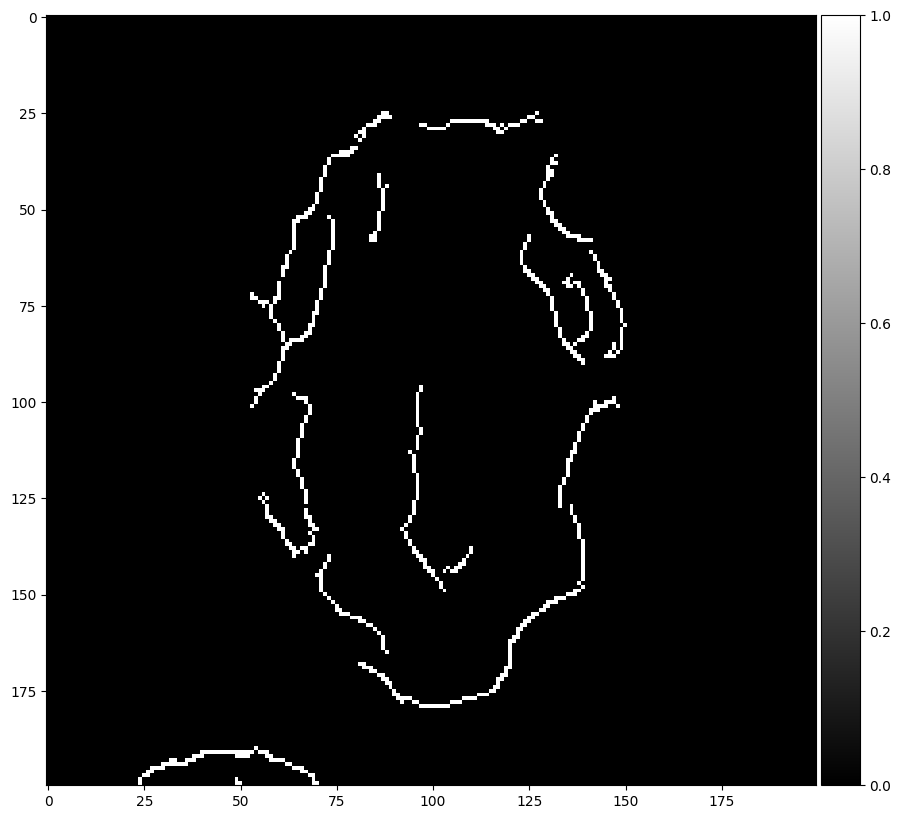

In [89]:
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

display_img_colorbar(crop_center(im_threshold, 200, 200))

In [97]:
def preprocessing_filtering(img, ksize_sobel, ksize_gaussian, sigma_gassuain, threshold_canny, crop_window_size):
  # convert to grayscale
  if np.max(img)>1:
    img = img.astype(np.float32)/255.0
  im_gray = np.mean(img, axis=2)

  # compute edges of the image
  # the larger kernel size is, the clearer the image we have. Small kernal would make the image fuzzy and full of noises.
  sobelx = cv2.Sobel(im_gray, cv2.CV_32F, 1, 0, ksize=ksize_sobel) # Find x and y gradients
  sobely = cv2.Sobel(im_gray, cv2.CV_32F, 0, 1, ksize=ksize_sobel)
  magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
  magnitude = magnitude / np.max(magnitude) # normalize

  blurred_im = cv2.GaussianBlur(magnitude, ksize_gaussian, sigmaX=sigma_gassuain[0], sigmaY=sigma_gassuain[1])

  blurred_im = blurred_im / np.max(blurred_im)
  blurred_im_8u = np.uint8(blurred_im * 255)
  high_threshold = threshold_canny[0]
  low_threshold = threshold_canny[1]
  im_threshold = cv2.Canny(image=blurred_im_8u, threshold1=low_threshold, threshold2=high_threshold) # Canny Edge
  im_threshold = im_threshold / np.max(im_threshold)

  return crop_center(im_threshold, crop_window_size[0], crop_window_size[1])

# display_img_colorbar(preprocessing_filtering(im, ksize_sobel=31, ksize_gaussian=(7, 7), sigma_gassuain=(16, 10), threshold_canny=(120,30), crop_window_size=(200, 200)))

In [71]:
# directory = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/'
# foldername = []

# for item in os.listdir(directory):
#   foldername.append(directory+item)

# for folder_dir in foldername:
#   print(folder_dir)
#   image_files = os.listdir(folder_dir)
#   print(len(image_files))
#   image_path = os.path.join(folder_dir, image_files[0])
#   im = np.array(Image.open(image_path))
#   display_img_colorbar(preprocessing_filtering(im))

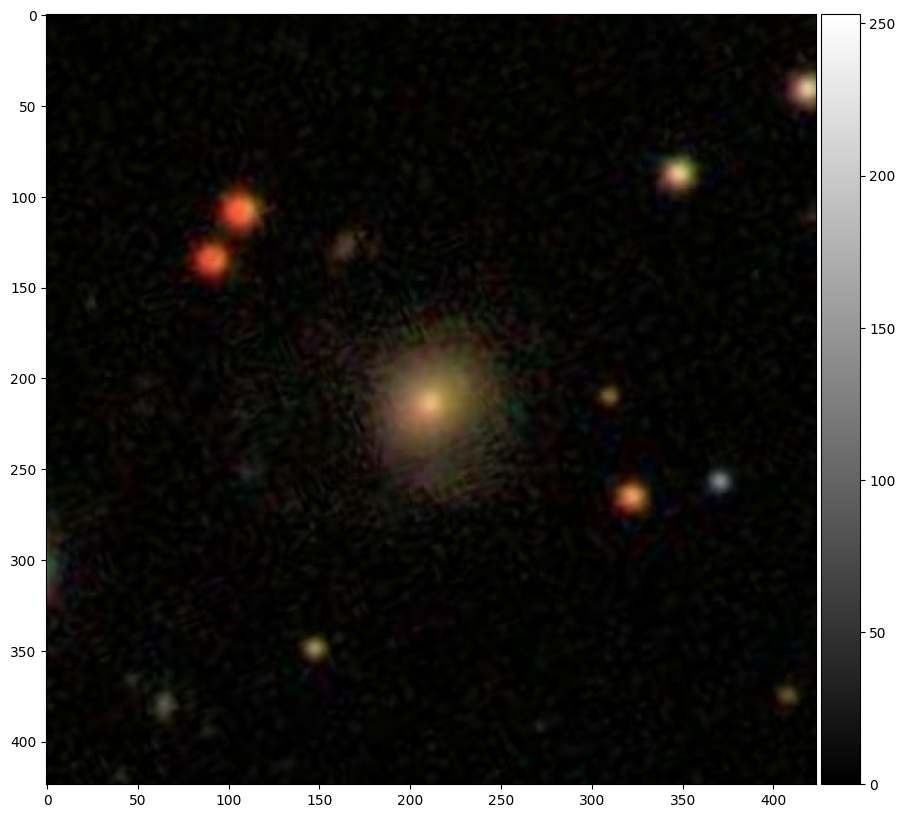

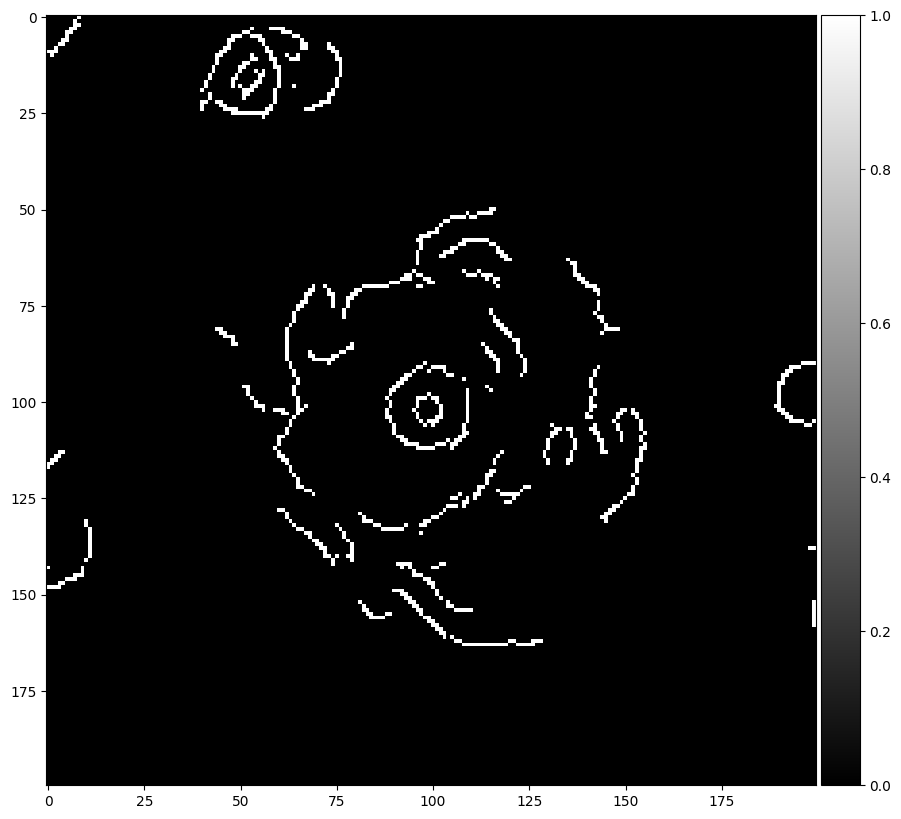

In [104]:
folder_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/completely round smooth'
image_files = os.listdir(folder_dir)
image_path = os.path.join(folder_dir, image_files[0])
im = np.array(Image.open(image_path))
display_img_colorbar(im)
display_img_colorbar(preprocessing_filtering(im, ksize_sobel=31, ksize_gaussian=(7, 7), sigma_gassuain=(30, 30), threshold_canny=(40,30), crop_window_size=(200, 200)))